# Méthodes de combinaison

La combinaison de classifieurs indépendants peut se réaliser suivant deux principes : soit par pondération, soit par méta-apprentissage. La première classe de méthodes trouve son intérêt lorsque les classifieurs réalisent la même tâche avec approximativement le même succès. La seconde est plus particulièrement adaptée lorsque certains classifieurs classifient systématiquement bien (ou mal) certains exemples.

## Méthodes de pondération

Il existe de très nombreuses méthodes de pondération. Nous présentons dans la suite certaines d'entre elles, à partir desquelles d'autres peuvent facilement être dérivées.
### Vote par majorité
Un point $\mathbf x$ est affecté à la classe qui a reçu le plus grand nombre de votes de la part des $M$ classifieurs.
### Pondération par performance
Le poids de chaque classifieur est proportionnl à sa précision sur un ensemble de validation : 

$$\alpha_i = \frac{1-A_i}{\displaystyle\sum_{j=1}^M(1-A_j)}$$

où $A_i$ est un indice de performance de $h_i$ calculé sur l'ensemble de validation.

### Sommation de distributions
L'idée de cette méthode de pondération est de sommer les vecteurs de probabilités conditionnelles obtenues par chaque classifieur. Un point $\mathbf x$ est affecté à la classe de score le plus élevé dans le vecteur somme :

$$classe(\mathbf x) = arg \max_{v\in domaine(y)}\displaystyle\sum_{i=1}^M \hat{P}_{h_i}(y=v|X)$$

### Combinaison bayésienne
Le poids de chaque classifieur est la probabilité a posteriori du classifieur, étant donné $Z$ : 

$$classe(\mathbf x) = arg \max_{v\in domaine(y)}\displaystyle\sum_{i=1}^M P(h_i|Z).\hat{P}_{h_i}(y=v|X)$$

où $P(h_i|Z)$ est la probabilité que $h_i$ soit correct, étant donné $Z$, et dont l'estimation dépend de la représentation de $h_i$.

Le code suivant résente deux schémas de vote sur un ensemble de données non linéairement séparables. $M=3$ classifieurs (SVM, forêt aléatoire et classifieur logistique) sont utilisés dans cet exemple. Le tableau donne la précision des différents classifieurs utilisés.

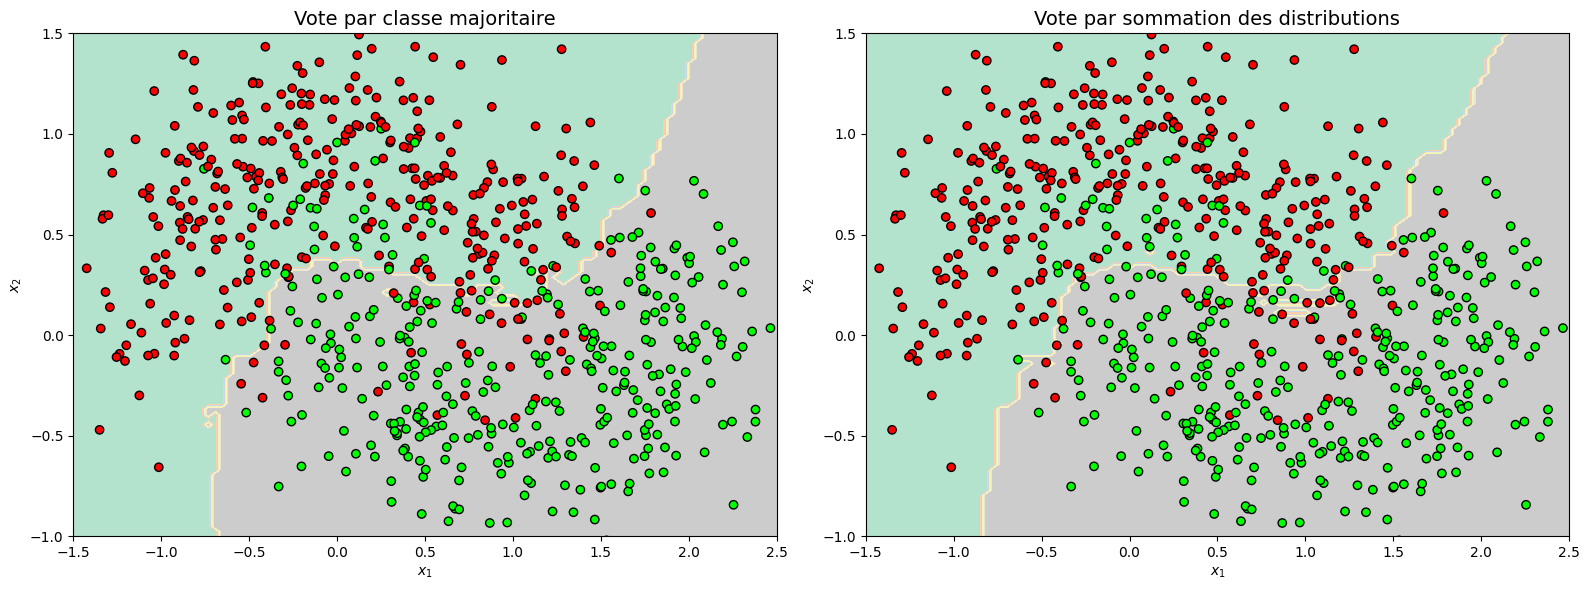

In [1]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    mapp = ListedColormap(['#FF0000', '#00FF00'])
    plt.contourf(x1, x2, y_pred, alpha=1, cmap="Pastel2")
    if contour:
        plt.contour(x1, x2, y_pred, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=mapp,edgecolors='k')
    plt.axis(axes)
    plt.xlabel(r"$x_1$",)
    plt.ylabel(r"$x_2$")

X, y = make_moons(n_samples=700, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(random_state=42,solver='lbfgs')
rnd_clf = RandomForestClassifier(random_state=42,n_estimators=100)
svm_clf = SVC(random_state=42,gamma='auto')

# On vote tout d'abord sur la majorité des labels exprimés par les classifieurs
voting1_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                           ('rf', rnd_clf), 
                                           ('svc', svm_clf)],voting='hard')
voting1_clf.fit(X_train, y_train)

svm_clf = SVC(probability=True, random_state=42,gamma='auto')
# On vote ensuite sur l'argmax de la somme des probabilités prédites 
# par les classifieurs (cas de classifieurs bien calibrés).
voting2_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                           ('rf', rnd_clf), 
                                           ('svc', svm_clf)],voting='soft')
voting2_clf.fit(X_train, y_train)



plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_decision_boundary(voting1_clf, X, y,contour=False)
plt.title("Vote par classe majoritaire", fontsize=14)
plt.subplot(1,2,2)
plot_decision_boundary(voting2_clf, X, y,contour=False)
plt.title("Vote par sommation des distributions", fontsize=14)
plt.tight_layout()

| Classifieur                          | Précision |
|--------------------------------------|-----------|
| Logistique                           | 0.891     |
| Forêt aléatoire                      | 0.874     |
| SVM                                  | 0.903     |
| Vote par classe majoritaire          | 0.903     |
| Vote par sommation des distributions | 0.909     |





## Méthodes par méta apprentissage
### Empilement
L'objectif de cette méthode est d'augmenter la capacité de généralisation du classifieur fort $h$. Des méta données sont crées à partir des prédictions des classifieurs sur les données de $Z$ . Un nouvel algorithme d'apprentissage est alors utilisé sur ces méta données, pour prédire quelles combinaisons des classifieurs faibles donne de bons résultats. 

La méthode originale dite de stacking naïf  est présenté dans l'{prf:ref}`stacking-algorithm`.


```{prf:algorithm} 
:label: stacking-algorithm
**Entrée** : l'ensemble d'apprentissage $Z$, $M$

**Sortie** : Un classifieur $h$


Pour $i= 1$ à $M$
  1. Construire un classifieur $h_i$ sur $Z$

$Z^*=\emptyset$

Pour $j= 1$ à $n$
  1. Ajouter$ (\mathbf x_j^*,y_j)$ à $Z^*$, où $\mathbf x_j^*=\left (h_1(\mathbf x_j)\ldots  h_M(\mathbf x_j)\right )^T$

Apprendre $h$ sur $Z^*$
```



Le stacking naïf peut facilement faire du surapprentissage, si un ou plusieurs des classifieurs $h_i$ sur-apprennent. Pour limiter cet effet, un algorithme basé sur la validation croisée ({prf:ref}`CV-algorithm`) est proposé.



```{prf:algorithm} 
:label: CV-algorithm
**Entrée** : l'ensemble d'apprentissage $Z$, $M$

**Sortie** : Un classifieur $h$

$Z^*=\emptyset$

Créer $k$ sous ensembles $ Z=\displaystyle\cup_{i=1}^k Z_i$ aléatoirement à partir de $Z$



Pour $j= 1$ à $k$
  1. Pour $i= 1$ à $M$ : Construire un classifieur $h_i$ sur $Z\setminus Z_j$
  2. Pour $i= 1$ à $n\in |Z\setminus Z_j|$ : Ajouter$ (\mathbf x_j^*,y_j)$ à $Z^*$, où $\mathbf x_j^*=\left (h_1(\mathbf x_i)\ldots  h_M(\mathbf x_i)\right )^T$

Apprendre $h$ sur $Z^*$
```



### Apprentissage par grading
Cette méthode transforme les classifications produites par les $M$ classifieurs en $M$ ensembles d'entrainement , en utilisant les exemples $\mathbf x_i$  $M$ fois, avec un nouveau label binaire pour chaque occurrence, indiquant si le k-ième classifieur a correctement ou non classé $\mathbf x_i$. Pour chaque classifieur, un méta-classifieur est entrainé, qui prédit quand le classifieur tend à mal classer un exemple donné. Le classifieur fort $h$ est construit à partir des classifieurs faibles reconnus comme fiables par les méta classifieurs. 

Cette méthode s'apparente à une généralisation de la sélection par validation croisée.